# Week 3 Project: CNN Cancer Detection Kaggle Mini-Project

## Step 1: Data and Problem Statement
For this project I will be using data from https://www.kaggle.com/c/histopathologic-cancer-detection/overview.

The purpose is to use deep learning models to classify whether or not mestatic cancer is present in images. Convolutional Neural Networks will as they were the focus of this week. The goal is to identify metastatic cancer in small image patches taken from larger digital pathology scans.

### Setup
Imports and Installations

In [126]:
!pip install tensorflow

In [1]:
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
import os
import seaborn
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import zipfile
from PIL import Image
import pickle
import sys
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
print(tf.__version__)
keras.__version__

2.18.0


'3.6.0'

### Data
According to the Kaggle description, a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

In [34]:
## Load the image labels for the train data

train_labels_df = pd.read_csv("data/train_labels.csv")
train_labels_df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [36]:
## Function that loads data from the filesystem in the form of file location

def load_tif_images_to_dataframe(directory):
    image_data = []
    for filename in os.listdir(directory):
        if filename.endswith(".tif"):
            filepath = os.path.join(directory, filename)
        try:
            img = Image.open(filepath)
            image_data.append({'filepath': filepath})
            img.close()
        except Exception as e:
            pass
            print(f"Error loading image {filename}: {e}")
    return pd.DataFrame(image_data)

In [38]:
train_df = load_tif_images_to_dataframe("data/train")
train_df

,filepath
0,data/train/f0c2a0b8ef3024f407fa97d852d49be0215...
1,data/train/99ef485f205645918613cd04281098daa7c...
2,data/train/e2612e173abd0e8bb54a3c3db3f264b63d8...
3,data/train/6d1bb57c0606f05dbd75f90a8d9e21a57e1...
4,data/train/9c043ab2adadfeb758c71d21432fccd3e43...
...,...
220020,data/train/7a5f23a002018cd828cc5e8df89de79850d...
220021,data/train/7cd369c04a37c9da20bbfe1bcba2cfad754...
220022,data/train/b21c0dc5ba97639f3b5c62ffe00364cfb0c...
220023,data/train/d16dbdaf3b5cea4b5f6629e2a487f0e0107...


In [39]:
train_df['id'] = train_df['filepath'].apply(lambda x: os.path.basename(x).split('.')[0])
train_df = train_df[train_df['id'] != '_labels']
train_df

,filepath,id
0,data/train/f0c2a0b8ef3024f407fa97d852d49be0215...,f0c2a0b8ef3024f407fa97d852d49be0215cafe0
1,data/train/99ef485f205645918613cd04281098daa7c...,99ef485f205645918613cd04281098daa7c17819
2,data/train/e2612e173abd0e8bb54a3c3db3f264b63d8...,e2612e173abd0e8bb54a3c3db3f264b63d80bffb
3,data/train/6d1bb57c0606f05dbd75f90a8d9e21a57e1...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0
4,data/train/9c043ab2adadfeb758c71d21432fccd3e43...,9c043ab2adadfeb758c71d21432fccd3e43565c0
...,...,...
220020,data/train/7a5f23a002018cd828cc5e8df89de79850d...,7a5f23a002018cd828cc5e8df89de79850d01050
220021,data/train/7cd369c04a37c9da20bbfe1bcba2cfad754...,7cd369c04a37c9da20bbfe1bcba2cfad754fc100
220022,data/train/b21c0dc5ba97639f3b5c62ffe00364cfb0c...,b21c0dc5ba97639f3b5c62ffe00364cfb0c11b40
220023,data/train/d16dbdaf3b5cea4b5f6629e2a487f0e0107...,d16dbdaf3b5cea4b5f6629e2a487f0e01075ba58


In [40]:
train_data_df = pd.merge(train_df, train_labels_df, on='id').drop(columns = ['id'])
train_df = None # Resetting for system memory
train_labels_df = None # Resetting for system memory
print(Counter(train_data_df.label))
print(train_data_df.info())
train_data_df

Counter({0: 130908, 1: 89117})
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filepath  220025 non-null  object
 1   label     220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None


,filepath,label
0,data/train/f0c2a0b8ef3024f407fa97d852d49be0215...,0
1,data/train/99ef485f205645918613cd04281098daa7c...,1
2,data/train/e2612e173abd0e8bb54a3c3db3f264b63d8...,1
3,data/train/6d1bb57c0606f05dbd75f90a8d9e21a57e1...,0
4,data/train/9c043ab2adadfeb758c71d21432fccd3e43...,1
...,...,...
220020,data/train/7a5f23a002018cd828cc5e8df89de79850d...,1
220021,data/train/7cd369c04a37c9da20bbfe1bcba2cfad754...,1
220022,data/train/b21c0dc5ba97639f3b5c62ffe00364cfb0c...,0
220023,data/train/d16dbdaf3b5cea4b5f6629e2a487f0e0107...,0


The resulting dataset includes approximately 220000 files. The class distribution is 130908 at label 0 (no cancer) and 89117 at label 1 (yes cancer), resulting in an approximate 1.47:1 ratio of non cancer to cancer present images. These files will be loaded into actual images for model training in later sections.

## Step 2: Exploratory Data Analaysis
Data will be inspected, analyzed, and cleaned as required. Based on the Kaggle description, duplicates have already been removed since the Kaggle dataset is a sample of the data from PatchCamelyon.

Since the Kaggle test dataset does not contain labels and is only used for project submisson, a validation data set for supervised classification will need to be made with the training data. I will use a 70%-30% split, setting random_state to 0 for reproducibility.

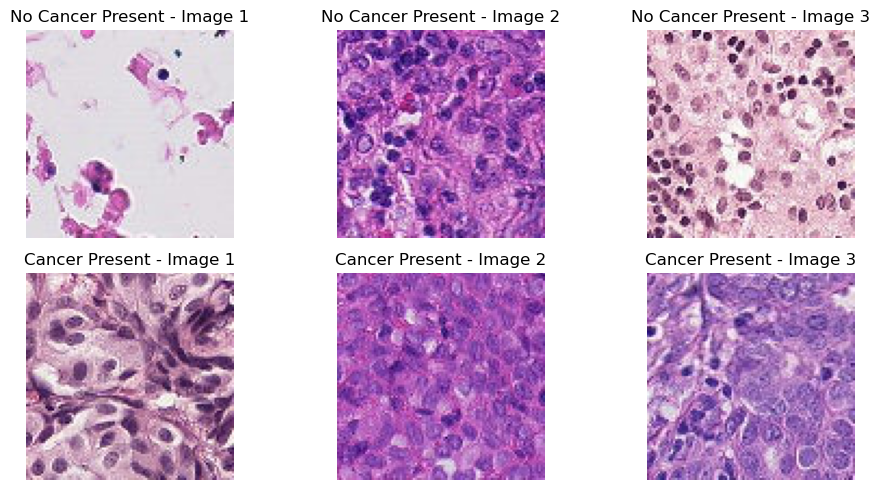

In [44]:
## Display images of each class

label_0 = train_data_df[train_data_df['label'] == 0][0:3]
label_1 = train_data_df[train_data_df['label'] == 1][0:3]

plt.figure(figsize=(10, 5))

for i in range(3):
    # Label 0 images
    img_path = label_0.iloc[i]['filepath']
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f'No Cancer Present - Image {i+1}')
    plt.axis('off')

for i in range(3):
    # Label 1 images
    img_path = label_1.iloc[i]['filepath']
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 4)
    plt.imshow(img)
    plt.title(f'Cancer Present - Image {i+1}')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

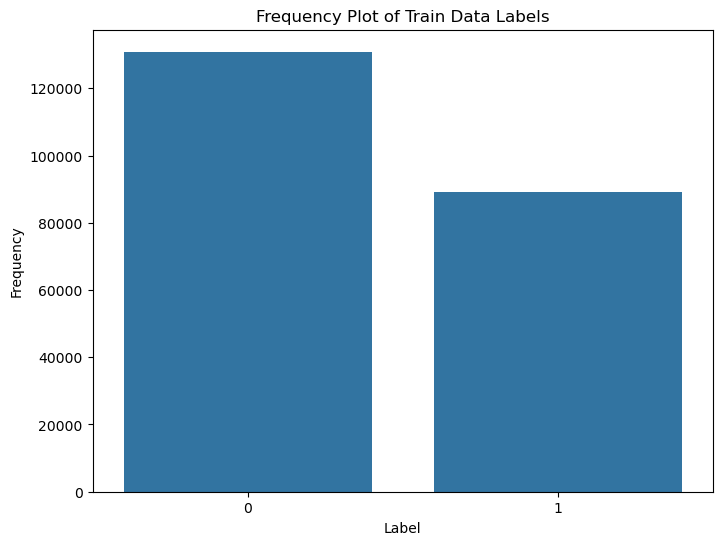

In [45]:
## Display a frequency plot of the train data label distribution

label_counts = train_data_df['label'].value_counts()
plt.figure(figsize=(8, 6))
seaborn.countplot(x='label', data=train_data_df)
plt.title('Frequency Plot of Train Data Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [46]:
## Setup the train and validation data for model development

train_df, validation_df = train_test_split(train_data_df, test_size = 0.3, random_state = 0)
train_data_df = None # Reseting for memory

In [47]:
validation_df

,filepath,label
155115,data/train/e3424e29c515bc20ae7fdd84b742aadd0f1...,0
145742,data/train/0c8492c5ab94a2a011452d34c6019ba691b...,0
105400,data/train/cc1191e93b9c344bd12cb240e1122622081...,0
61543,data/train/5bf7dbaddc83ab08f162d451a63470acb2b...,0
32978,data/train/74e8d06b196e97b94aab93207681b34f4a3...,0
...,...,...
180112,data/train/2c8dd8ef25e1ef661115742b8b4977f5274...,1
192655,data/train/c30795e221aa96b940cc5d795ceaebeead9...,1
124067,data/train/0c29b70885ed002397d2bae068e2fbb55c3...,0
122609,data/train/cf8076828ab540a9f46f8e2a94fbad0689a...,1


In [48]:
## Setup data for ImageDataGenerator and flow_from_dataframe

train_df['label'] = train_df['label'].astype(str)
validation_df['label'] = validation_df['label'].astype(str)

In [51]:
## Obtain image dimensions

image = Image.open(train_df.iloc[0]['filepath'])
width, height = image.size
batch_size = 64
img_size = (width, height)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
print("Image shape:", img_shape)

Image shape: (96, 96, 3)


In [53]:
## Transform the train and validation data for use by keras

train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepath',
    y_col = 'label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'binary')
train_df = None # Reset for memory

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = validation_df,
    x_col = 'filepath',
    y_col = 'label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode= 'binary')
validation_df = None # Reset for memory

Found 154017 validated image filenames belonging to 2 classes.
Found 66008 validated image filenames belonging to 2 classes.


In [ ]:
## Setup test data, only file paths needed for now as the images will be loaded later for prediction

def load_filepaths(directory):
    file_paths = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        file_paths.append(filepath)
    test_data_prepared = pd.DataFrame({'file_paths': file_paths})
    file_paths = None
    return test_data_prepared

test_data_prepared = load_filepaths("data/test")
test_data_prepared

In this section I prepared the data by normalizing the pixels of the images using a 1/255 scaling to give values between 0 and 1. The batch size for the training data is set to 64. I also setup the train and validation split. The images dimensions are set to the image size of 96 by 96, with 3 on the third dimensions for RGB. None of the images needed to be cleaned or removed. Duplicates were already moved according to the Kaggle data description.

## Steps 3-4 Model Architecture, Results, Analysis
In this section deeplearning CNN models will be created, trained, and evaluated. The models used will include:
1. Base model with just a Dense layer.
2. Model using Max Pooling layers.
3. Model using Average pooling layers.

The purpose of these architecture choices is to compare the performance of these methods used in class lectures.

I will define the model architectures, train the models, and evaluate the results. For the purposes of my computers hardware limitations, the models were trained, saved, and reloaded later with all other variables cleared so I could have enough RAM for training and predicting using these models.

In [56]:
## Simple dense layer model for baseline

model_base = keras.Sequential([
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_base.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_base = model_base.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

loss_base, accuracy_base = model_base.evaluate(validation_generator)
print(f"Validation Loss: {loss_base}")
print(f"Validation Accuracy: {accuracy_base}")

model_base.save('models/model_base.keras')

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2407/2407 ━━━━━━━━━━━━━━━━━━━━ 77s 32ms/step - accuracy: 0.5795 - loss: 0.9755 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 2/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 77s 32ms/step - accuracy: 0.5918 - loss: 0.6763 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 3/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 75s 31ms/step - accuracy: 0.5937 - loss: 0.6755 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 4/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 76s 31ms/step - accuracy: 0.5950 - loss: 0.6750 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 5/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 76s 32ms/step - accuracy: 0.5936 - loss: 0.6755 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 6/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 76s 31ms/step - accuracy: 0.5933 - loss: 0.6757 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 7/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 76s 32ms/step - accuracy: 0.5940 - loss: 0.6754 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 8/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 77s 32ms/step - accuracy: 0.5964 - loss: 0.67

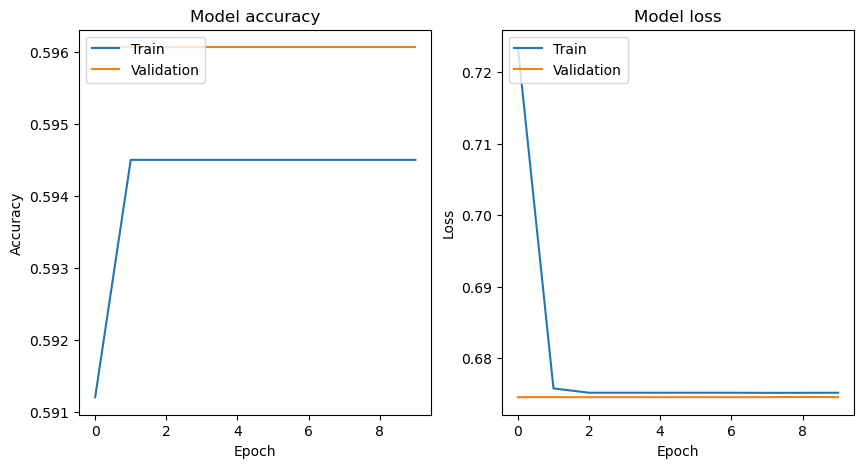

In [57]:
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'])
plt.plot(history_base.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'])
plt.plot(history_base.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step
              precision    recall  f1-score   support

           0       0.60      1.00      0.75     39345
           1       0.00      0.00      0.00     26663

    accuracy                           0.60     66008
   macro avg       0.30      0.50      0.37     66008
weighted avg       0.36      0.60      0.45     66008



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


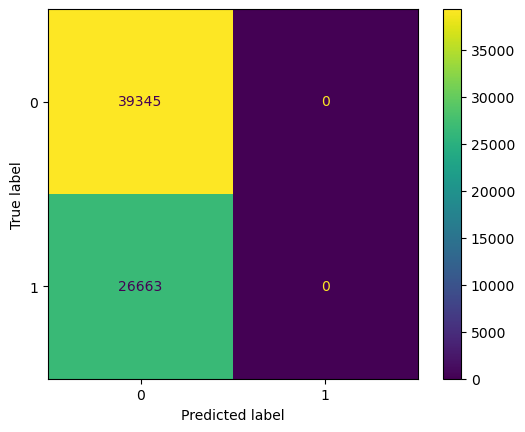

In [58]:
## Generate a classification report and confusion matrix for the validation predictions

validation_predictions = model_base.predict(validation_generator)
validation_pred_labels = (validation_predictions > 0.5).astype(int)

# Get true labels
validation_true_labels = validation_generator.classes

# Generate classification report
class_report = classification_report(validation_true_labels, validation_pred_labels)
print(class_report)

# Generate confusion matrix
cm = confusion_matrix(validation_true_labels, validation_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1'])
disp.plot()
plt.show()

In [61]:
model_base = keras.models.load_model('models/model_base.keras')
predictions = []
with open(os.devnull, 'w') as devnull:
    old_stdout = sys.stdout
    sys.stdout = devnull
    try:
        # Iterate over test image filepaths
        for filepath in test_data_prepared.file_paths:
            # Load and preprocess the image
            img = Image.open(filepath)
            img = img.resize(img.size)
            img_array = np.array(img) / 255.0 # Normalize pixel values
            img.close()
            img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
            prediction = model_base.predict(img_array)
            predictions.append(prediction[0][0])
        results = pd.DataFrame({'id': test_data_prepared.file_paths, 'label': predictions})
        results['label'] = results['label'].round()
        results['id'] = results['id'].apply(lambda x: os.path.basename(x).split('.')[0])
    finally:
        sys.stdout = old_stdout
model_base = None
results.to_csv('results/model_base_results.csv', index=False)   

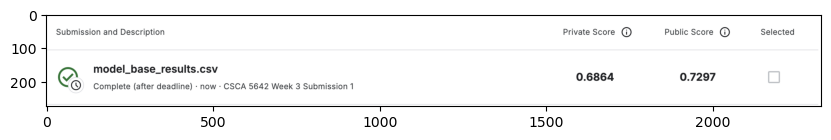

In [68]:
img = Image.open("results/model_base_results_kaggle.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)

The baseline model appears to overpredict the majority class. It is notable that after 1 epoch the train and validation loss and accuracy stagnated, meaning the number of epochs required was overshot. The Kaggle score obtained however, was approximately 73%.


#### Max Pooling

In [59]:
## Create a CNN using max pooling layers

model_max_pooling = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_max_pooling.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_max_pooling = model_max_pooling.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

loss_max_pooling, accuracy_max_pooling = model_max_pooling.evaluate(validation_generator)
print(f"Validation Loss: {loss_max_pooling}")
print(f"Validation Accuracy: {accuracy_max_pooling}")

model_max_pooling.save('models/model_max_pooling.keras')

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2407/2407 ━━━━━━━━━━━━━━━━━━━━ 200s 83ms/step - accuracy: 0.7554 - loss: 0.4981 - val_accuracy: 0.8251 - val_loss: 0.3968
Epoch 2/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 202s 84ms/step - accuracy: 0.8264 - loss: 0.3929 - val_accuracy: 0.8423 - val_loss: 0.3633
Epoch 3/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 197s 82ms/step - accuracy: 0.8439 - loss: 0.3598 - val_accuracy: 0.8457 - val_loss: 0.3618
Epoch 4/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 197s 82ms/step - accuracy: 0.8565 - loss: 0.3331 - val_accuracy: 0.8475 - val_loss: 0.3452
Epoch 5/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 200s 83ms/step - accuracy: 0.8671 - loss: 0.3118 - val_accuracy: 0.8535 - val_loss: 0.3392
Epoch 6/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 201s 84ms/step - accuracy: 0.8767 - loss: 0.2914 - val_accuracy: 0.8543 - val_loss: 0.3400
Epoch 7/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 203s 84ms/step - accuracy: 0.8876 - loss: 0.2692 - val_accuracy: 0.8598 - val_loss: 0.3373
Epoch 8/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 202s 84ms/step - accuracy: 0.9009 - lo

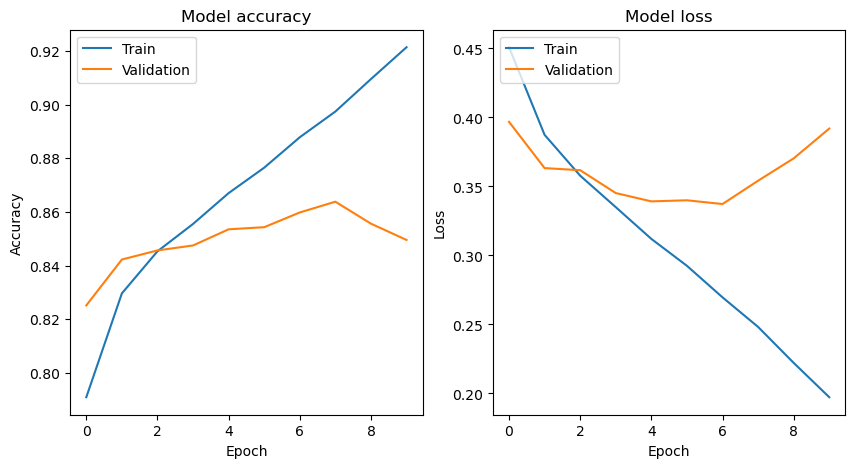

In [60]:
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_max_pooling.history['accuracy'])
plt.plot(history_max_pooling.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_max_pooling.history['loss'])
plt.plot(history_max_pooling.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# plt.tight_layout()
plt.show()

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step
              precision    recall  f1-score   support

           0       0.60      0.55      0.58     39345
           1       0.41      0.46      0.43     26663

    accuracy                           0.51     66008
   macro avg       0.51      0.51      0.50     66008
weighted avg       0.52      0.51      0.52     66008



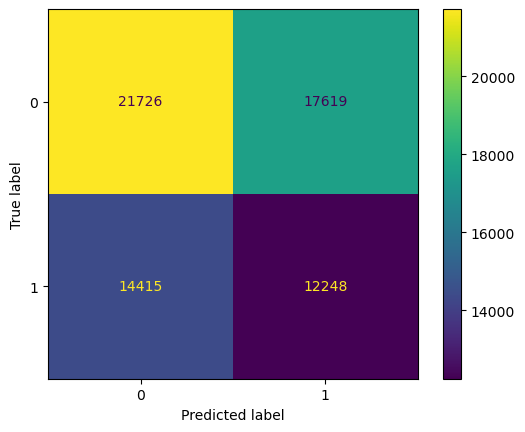

In [61]:
## Generate a classification report and confusion matrix for the validation predictions

validation_predictions = model_max_pooling.predict(validation_generator)
validation_pred_labels = (validation_predictions > 0.5).astype(int)

# Get true labels
validation_true_labels = validation_generator.classes

# Generate classification report
class_report = classification_report(validation_true_labels, validation_pred_labels)
print(class_report)

# Generate confusion matrix
cm = confusion_matrix(validation_true_labels, validation_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1'])
disp.plot()
plt.show()

In [ ]:
model_max_pooling = keras.models.load_model('models/model_max_pooling.keras')
predictions = []
with open(os.devnull, 'w') as devnull:
    old_stdout = sys.stdout
    sys.stdout = devnull
    try:
        # Iterate over test image filepaths
        for filepath in test_data_prepared.file_paths:
            # Load and preprocess the image
            img = Image.open(filepath)
            img = img.resize(img.size) # Assuming img_size is defined from previous code
            img_array = np.array(img) / 255.0 # Normalize pixel values
            img.close()
            img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
            prediction = model_max_pooling.predict(img_array)
            predictions.append(prediction[0][0])
        results = pd.DataFrame({'id': test_data_prepared.file_paths, 'label': predictions})
        results['label'] = results['label'].round()
        results['id'] = results['id'].apply(lambda x: os.path.basename(x).split('.')[0])
    finally:
        sys.stdout = old_stdout
model_max_pooling = None
results.to_csv('results/model_max_pooling_results.csv', index=False)   

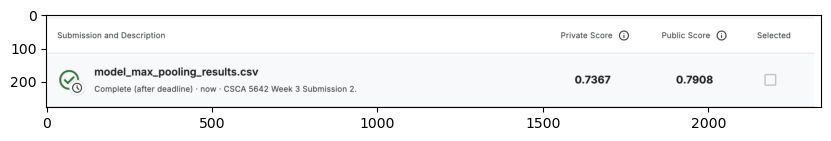

In [74]:
img = Image.open("results/model_max_pooling_results_kaggle.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)

The Kaggle score obtained was approximately 79%. This is an increase over the base dense layer model. Based on the plots, the model does not stagnate early like with the base model, indicating a best epoch range of 4-6 epochs for validation accuracy and loss.

#### Average Pooling

In [62]:
## Create a CNN model using average pooling layers

model_average_pooling = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_average_pooling.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_avg_pooling = model_average_pooling.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

loss_avg_pooling, accuracy_avg_pooling = model_average_pooling.evaluate(validation_generator)
print(f"Validation Loss: {loss_avg_pooling}")
print(f"Validation Accuracy: {accuracy_avg_pooling}")

model_average_pooling.save('models/model_average_pooling.keras')

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2407/2407 ━━━━━━━━━━━━━━━━━━━━ 193s 80ms/step - accuracy: 0.7684 - loss: 0.4913 - val_accuracy: 0.8288 - val_loss: 0.3985
Epoch 2/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 192s 80ms/step - accuracy: 0.8257 - loss: 0.3961 - val_accuracy: 0.8407 - val_loss: 0.3682
Epoch 3/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 196s 82ms/step - accuracy: 0.8429 - loss: 0.3590 - val_accuracy: 0.8426 - val_loss: 0.3595
Epoch 4/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 198s 82ms/step - accuracy: 0.8549 - loss: 0.3352 - val_accuracy: 0.8594 - val_loss: 0.3290
Epoch 5/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 197s 82ms/step - accuracy: 0.8672 - loss: 0.3091 - val_accuracy: 0.8548 - val_loss: 0.3447
Epoch 6/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 197s 82ms/step - accuracy: 0.8789 - loss: 0.2857 - val_accuracy: 0.8683 - val_loss: 0.3185
Epoch 7/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 198s 82ms/step - accuracy: 0.8921 - loss: 0.2594 - val_accuracy: 0.8680 - val_loss: 0.3122
Epoch 8/10
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 199s 83ms/step - accuracy: 0.9014 - lo

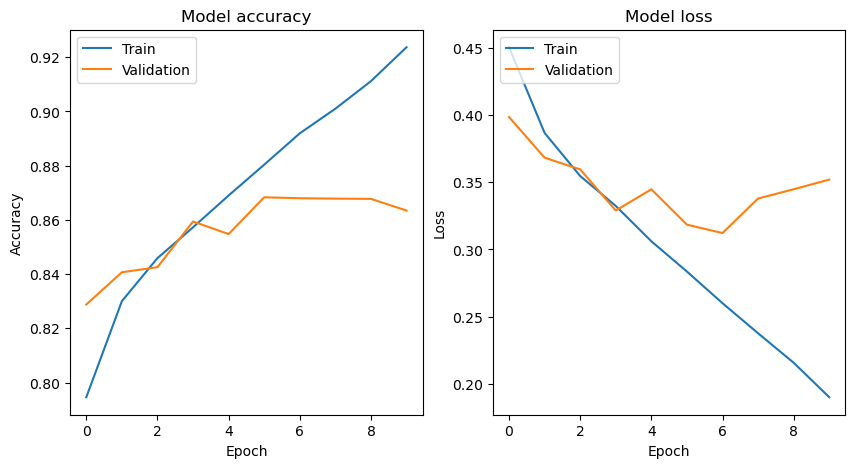

In [63]:
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_avg_pooling.history['accuracy'])
plt.plot(history_avg_pooling.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_avg_pooling.history['loss'])
plt.plot(history_avg_pooling.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# plt.tight_layout()
plt.show()

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step
              precision    recall  f1-score   support

           0       0.60      0.57      0.58     39345
           1       0.40      0.43      0.42     26663

    accuracy                           0.51     66008
   macro avg       0.50      0.50      0.50     66008
weighted avg       0.52      0.51      0.51     66008



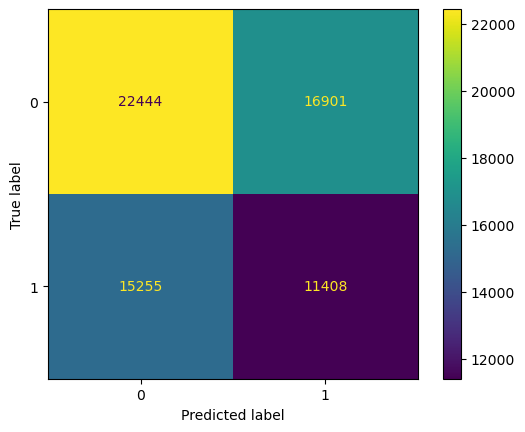

In [64]:
## Generate a classification report and confusion matrix for the validation predictions

validation_predictions = model_average_pooling.predict(validation_generator)
validation_pred_labels = (validation_predictions > 0.5).astype(int)

# Get true labels
validation_true_labels = validation_generator.classes

# Generate classification report
class_report = classification_report(validation_true_labels, validation_pred_labels)
print(class_report)

# Generate confusion matrix
cm = confusion_matrix(validation_true_labels, validation_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1'])
disp.plot()
plt.show()

In [59]:
model_average_pooling = keras.models.load_model('models/model_average_pooling.keras')
predictions = []
with open(os.devnull, 'w') as devnull:
    old_stdout = sys.stdout
    sys.stdout = devnull
    try:
        # Iterate over test image filepaths
        for filepath in test_data_prepared.file_paths:
            # Load and preprocess the image
            img = Image.open(filepath)
            img = img.resize(img.size) # Assuming img_size is defined from previous code
            img_array = np.array(img) / 255.0 # Normalize pixel values
            img.close()
            img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
            prediction = model_average_pooling.predict(img_array)
            predictions.append(prediction[0][0])
        results = pd.DataFrame({'id': test_data_prepared.file_paths, 'label': predictions})
        results['label'] = results['label'].round()
        results['id'] = results['id'].apply(lambda x: os.path.basename(x).split('.')[0])
    finally:
        sys.stdout = old_stdout
model_average_pooling = None
results.to_csv('results/model_average_pooling_results.csv', index=False)   

The Kaggle score was approximately 80%, being about the same performance as the max pooling model and again better than the base model. According to the validation accuracy and loss, 6 epochs appears to best the best.

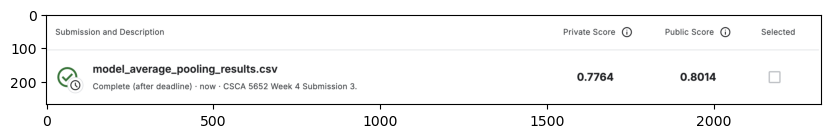

In [78]:
img = Image.open("results/model_average_pooling_results_kaggle.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)

## Step 5: Conclusion

The main takeaway regarding model selection indicates that using specialized max and average pooling layers results in better scores, with the best model I created resulting in a Kaggle score of 80%. These architectures result in a longer train time than the base model. Changing the number of epochs could include the model along with the number of layers used. If increasing the layers or neuron output size of layers, the total parameters would increase and therefore increase the chance of overfitting, so epoch count would change. Improvements that could be made would be to increase the number of layers to see how performance is affected. Also, mixing the layer types would be worthwhile. In terms of feature engineering, data augmentation could be used to increase the total training data. This could in part be used to balance the class distribution to see if this would increase the performance on the test set for Kaggle. Furthermore, using the same model architectures, parameters that could be changed include the loss funciton and optimizer choices.